In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [2]:
biomass_density = pd.read_csv('preprocessed/forecasted.csv')

In [3]:
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv')

In [4]:
distance_matrix = distance_matrix.drop('Unnamed: 0',axis=1)

In [5]:
biomass_density = biomass_density.drop('Unnamed: 0',axis=1)

In [6]:
distance_matrix.shape

(2418, 2418)

## Prprocessing

In [7]:
#new_distance = lambda den,dist: den/dist

In [8]:
biomass_density.head()

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233


In [9]:
distance_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,113.4309,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,111.1832,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,111.7859,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,82.5852,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,65.1442,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


## Modelling

In [10]:
year = '2018'

### Get initial point with most density of biomass

In [11]:
def get_most(column_name):
    density=biomass_density[column_name]
    return np.argmax(density)
    

### Get pobability based on biomass density

In [12]:
k=10

In [13]:
def set_prob_depots(density):
    sum_density=sum(density)
    prob=[x/sum_density for x in density]
    return prob

In [14]:
weights=set_prob_depots(biomass_density[year])

In [15]:
def get_depots(k,year,weights):
    depots=[]
    while len(depots)!=k :
        depots = np.random.choice(biomass_density[year].shape[0],size=k,p=weights)
    return list(depots)

In [16]:
biomass_density[year].shape[0]

2418

In [17]:
depots = get_depots(k,year,weights)

### Visualising Data

In [18]:
def plot_depots(depots,clusters=None,refineries=None):
    depots_location = biomass_density.loc[depots, ["Latitude", "Longitude"]]

    latitudes = biomass_density["Latitude"]
    longitudes = biomass_density["Longitude"]

    # Create a scatter plot
    plt.scatter(latitudes, longitudes,c=clusters)
    if(refineries!=None):
        refineries_location = biomass_density.loc[refineries, ["Latitude", "Longitude"]]
        plt.scatter(refineries_location['Latitude'],refineries_location['Longitude'],marker='o', color='white')
    
    plt.scatter(depots_location["Latitude"], depots_location["Longitude"], marker='x', color='red')

    # Add a title and labels
    plt.title('Latitude and Longitude')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    # Show the plot
    plt.show()

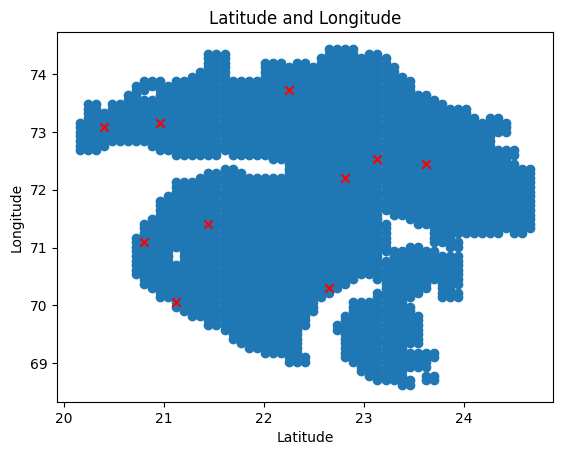

In [19]:
plot_depots(depots)

## Optimal clusters for depots

In [20]:
def re_cluster_depots(k,X,depots):
    belonging_to_cluster=np.array([])
    for i in range(X.shape[0]):
        distance=[distance_matrix.iloc[i,x] for x in depots]
        belonging_to_cluster=np.append(belonging_to_cluster,np.argmin(distance))

    depots = []
    for i in range(k):
        if len(X[belonging_to_cluster==i][['Latitude','Longitude']]) != 0:
            pseudo_coord = np.mean(X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy(),axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in X[belonging_to_cluster==i][['Latitude','Longitude']].to_numpy()]
            depots.append(X[belonging_to_cluster==i].iloc[np.argmin(distance),:].name)
        else:
            depots = get_depots(k,year,weights)
            re_cluster_depots(k,X,depots)
        
    return depots,belonging_to_cluster

In [21]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[1108, 2283, 1904, 2148, 917, 687, 2385, 1864, 180, 1299]


[1051, 2248, 1685, 2052, 589, 622, 2376, 1757, 178, 1298]
[1050, 2209, 1630, 1998, 588, 562, 2367, 1757, 177, 1239]
[1049, 2208, 1630, 1941, 587, 561, 2356, 1758, 175, 1239]
[1049, 2206, 1571, 1941, 648, 501, 2356, 1812, 174, 1183]
[1049, 2205, 1571, 1884, 648, 445, 2356, 1812, 173, 1183]
[1049, 2165, 1510, 1884, 648, 445, 2344, 1812, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]
[1049, 2163, 1

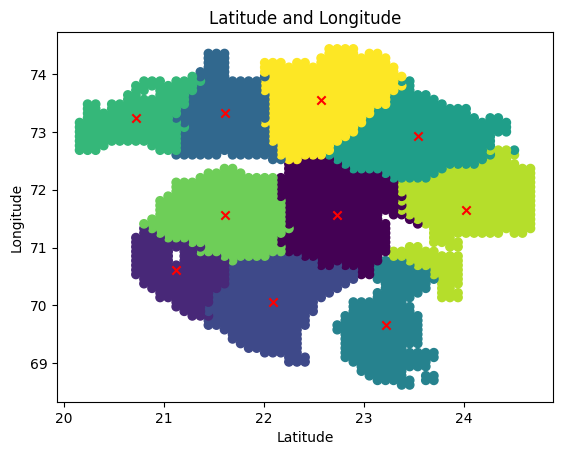

In [22]:
plot_depots(depots,clusters)

## Finding refineries

In [23]:
biomass_density

,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24.66818,71.33144,0.212466,0.225726,0.219358,0.169677,0.231301,0.205046,0.243113,0.180307,0.199934,0.502740
1,24.66818,71.41106,0.300711,0.333306,0.309579,0.259861,0.340509,0.328613,0.428428,0.362593,0.334189,0.518164
2,24.66818,71.49069,0.370192,0.440955,0.402816,0.350319,0.433291,0.380620,0.486443,0.435923,0.397611,0.511109
3,24.66818,71.57031,0.407901,0.471496,0.449079,0.371401,0.475138,0.449872,0.525324,0.485404,0.437328,0.541641
4,24.66818,71.64994,0.255002,0.292657,0.292995,0.243953,0.281919,0.291840,0.317984,0.309058,0.257460,0.509233
...,...,...,...,...,...,...,...,...,...,...,...,...
2413,20.15456,72.84432,0.180534,0.180260,0.170496,0.129193,0.180347,0.190154,0.231986,0.181932,0.177813,0.534950
2414,20.15456,72.92394,0.051700,0.054713,0.048782,0.044817,0.051860,0.054145,0.065674,0.051462,0.048789,0.564789
2415,20.15456,73.00357,0.035414,0.037422,0.033379,0.030625,0.035525,0.037108,0.044995,0.035245,0.034098,0.564997
2416,20.15456,73.08319,0.145447,0.121111,0.097915,0.099246,0.114721,0.119751,0.145269,0.113851,0.120770,0.528472


In [24]:
def biomass_per_depo(k,clusters,year):
    biomass=[]
    for i in range(k):
        biomass.append(sum(biomass_density[clusters==i][year]))
        #print(biomass)
    return biomass

In [25]:
biomass_per_depot=biomass_per_depo(k,clusters,year)
biomass_per_depot

[181.34268198499976,
 71.67914463000004,
 157.56069779400002,
 95.81797202500005,
 53.40842060530001,
 135.99551865,
 51.736710875,
 170.70645655900006,
 122.14461190800002,
 134.50143011199995]

In [26]:
depots

[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]

In [27]:
r=5

In [28]:
def set_prob_ref(density):
    sum_density = sum(density)
    prob = [x/sum_density for x in density]
    return prob

In [29]:
biomass_per_depot

[181.34268198499976,
 71.67914463000004,
 157.56069779400002,
 95.81797202500005,
 53.40842060530001,
 135.99551865,
 51.736710875,
 170.70645655900006,
 122.14461190800002,
 134.50143011199995]

In [30]:
weights=set_prob_ref(biomass_per_depot)
weights

[0.15434816822324515,
 0.06100904956487142,
 0.13410634949411324,
 0.08155459212932697,
 0.04545808961183535,
 0.11575134414265459,
 0.04403522913658262,
 0.14529524205416847,
 0.10396227131954759,
 0.11447966432365461]

In [62]:
def get_refineries(r,depots,weights):
    if len(weights)<r:
        r = len(weights)
    refineries_index = np.random.choice(len(weights),size=r,p=weights)
    #print(refineries_index)
    refineries = []
    for i in refineries_index:
        refineries.append(depots[i])
    return refineries

In [32]:
get_refineries(5,depots,weights)

[8 3 8 7 5]


[173, 1884, 173, 1865, 445]

In [33]:
refineries = get_refineries(r,depots,weights)
refineries

[8 6 7 3 9]


[173, 2344, 1865, 1884, 1183]

## Optimal clusters for refineries

In [34]:
def re_cluster_refineries(r,X,refineries):
    belonging_to_cluster=np.array([])
    for i in X:
        distance = [distance_matrix.iloc[i,x] for x in refineries]
        belonging_to_cluster = np.append(belonging_to_cluster,np.argmin(distance))
        
    X=np.array(X)
    refineries = []
    for i in range(r):
        if len(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy()) != 0:
            pseudo_coord = np.mean(biomass_density.iloc[X[belonging_to_cluster==i],[0,1]].to_numpy(), axis=0)
            distance = [np.linalg.norm(pseudo_coord - x) for x in biomass_density.iloc[:,[0,1]].to_numpy()]
            refineries.append(biomass_density.iloc[np.argmin(distance),:].name)
        else:
            refineries = get_refineries(r,depots,weights)
            re_cluster_refineries(r,X,refineries)
    return refineries,belonging_to_cluster

In [35]:
count=0
clusters_depots=[]
for _ in range(30):
    prev=refineries
    refineries,cluster_depots=re_cluster_refineries(r,depots,refineries)
    if np.array_equal(prev,refineries):
        break
    # print(refineries)
    count+=1
print(f"Convergence in : {count} iterations")

Convergence in : 1 iterations


In [36]:
def biomass_per_refineries(r,cluster_depots,biomass_per_depot):
    biomass=[]
    biomass_per_depot=np.array(biomass_per_depot)
    for i in range(r):
        biomass.append(sum(biomass_per_depot[cluster_depots==i]))
    return biomass

In [37]:
biomass_per_refinery = biomass_per_refineries(r,cluster_depots,biomass_per_depot)

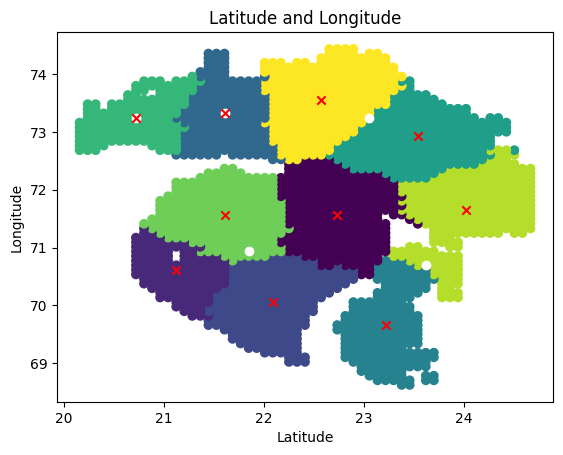

In [38]:
plot_depots(depots,clusters,refineries)

## Loss function for depots

In [39]:
biomass_per_depot

[181.34268198499976,
 71.67914463000004,
 157.56069779400002,
 95.81797202500005,
 53.40842060530001,
 135.99551865,
 51.736710875,
 170.70645655900006,
 122.14461190800002,
 134.50143011199995]

In [40]:
biomass_per_refinery

[175.55303251330002,
 51.736710875,
 581.2889809679998,
 95.81797202500005,
 270.496948762]

In [41]:
clusters

array([8., 8., 8., ..., 6., 6., 6.])

In [42]:
cluster_depots

array([2., 2., 2., 3., 0., 4., 1., 2., 0., 4.])

In [43]:
depots

[1049, 2164, 1510, 1884, 648, 445, 2344, 1865, 173, 1183]

In [44]:
refineries

[371, 2344, 1696, 1884, 825]

In [45]:
def loss_depot(depots,year):
    loss=[]
    for i in range(len(depots)):
        loss.append(sum([biomass_density.loc[x,year]*distance_matrix.iloc[x,depots[i]] for x in biomass_density[clusters==i].index]))
    #print(loss)
    return sum(loss)

In [46]:
def loss_refinery(refineries,cluster_depots,depots):
    loss=[]
    refineries=np.array(refineries)
    depots = np.array(depots)
    for i in range(len(refineries)):
        loss.append(sum([biomass_per_depot[x]*distance_matrix.iloc[depots[x],refineries[i]] for x in np.where(depots[cluster_depots==i])[0]]))
    #print(loss)
    return sum(loss)

In [47]:
loss_depot(depots,year)

86981.67728091936

In [48]:
loss_refinery(refineries,cluster_depots,depots)

371275.0341606592

### Optimal number for depots (2018)

In [49]:
k=range(1,26)

Convergence in : 1 iterations
Convergence in : 5 iterations


Convergence in : 6 iterations
Convergence in : 15 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 30 iterations
Convergence in : 19 iterations
Convergence in : 15 iterations
Convergence in : 9 iterations
Convergence in : 8 iterations
Convergence in : 13 iterations
Convergence in : 8 iterations
Convergence in : 12 iterations
Convergence in : 30 iterations
Convergence in : 30 iterations
Convergence in : 22 iterations
Convergence in : 7 iterations
Convergence in : 13 iterations
Convergence in : 20 iterations
Convergence in : 17 iterations
Convergence in : 7 iterations
Convergence in : 30 iterations
Convergence in : 9 iterations


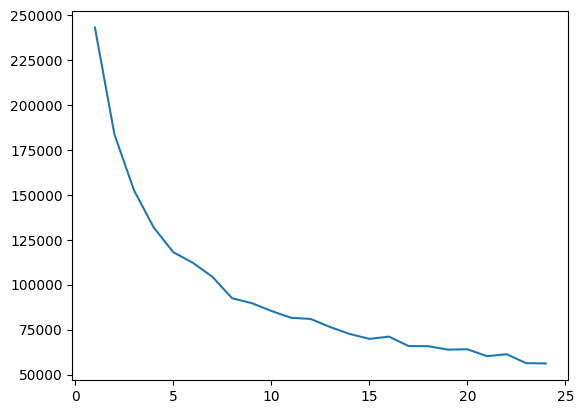

In [50]:
loss_d=[]
for i in k:
    year = '2018'
    weights = set_prob_depots(density=biomass_density[year])
    depots = get_depots(i,year,weights)
    
    count=0
    clusters=[]
    for _ in range(30):
        prev=depots
        depots,clusters=re_cluster_depots(i,biomass_density,depots)
        if np.array_equal(prev,depots):
            break
        #print(depots)
        count+=1
    loss_d.append(loss_depot(depots,year))
    print(f"Convergence in : {count} iterations")
plt.plot(k,loss_d)

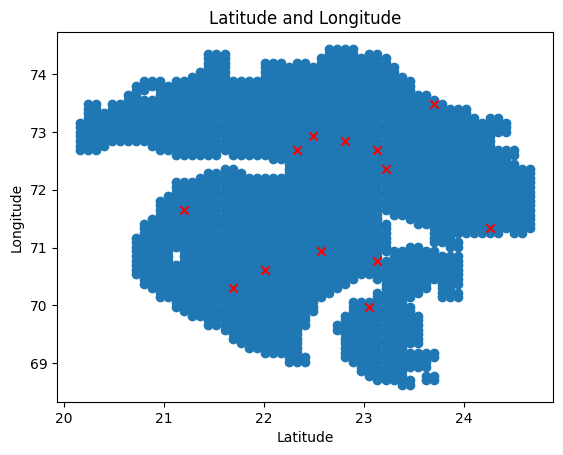

In [51]:
k = 13
weights = set_prob_depots(density=biomass_density[year])
depots = get_depots(k,year,weights)
plot_depots(depots)

In [52]:
count=0
clusters=[]
for _ in range(30):
    prev=depots
    depots,clusters=re_cluster_depots(k,biomass_density,depots)
    if np.array_equal(prev,depots):
        break
    print(depots)
    count+=1
print(f"Convergence in : {count} iterations")

[599, 1209, 890, 1833, 491, 1639, 645, 123, 314, 620, 1792, 2033, 1347]
[477, 1099, 1019, 2052, 490, 1638, 645, 98, 231, 619, 1737, 2082, 1347]
[476, 1045, 1076, 2100, 489, 1638, 645, 99, 230, 686, 1736, 2081, 1413]
[420, 1044, 1130, 2147, 489, 1637, 645, 99, 229, 755, 1682, 2080, 1412]
[420, 1043, 1184, 2147, 489, 1692, 645, 99, 229, 822, 1626, 2127, 1475]
[420, 1043, 1240, 2189, 549, 1799, 645, 99, 229, 822, 1567, 2128, 1474]
[370, 1042, 1240, 2189, 609, 1852, 645, 99, 229, 888, 1566, 2081, 1534]
[370, 1041, 1299, 2189, 675, 1908, 645, 99, 269, 889, 1567, 2081, 1533]
[370, 1095, 1299, 2189, 675, 1908, 645, 99, 269, 889, 1505, 2081, 1533]
Convergence in : 9 iterations


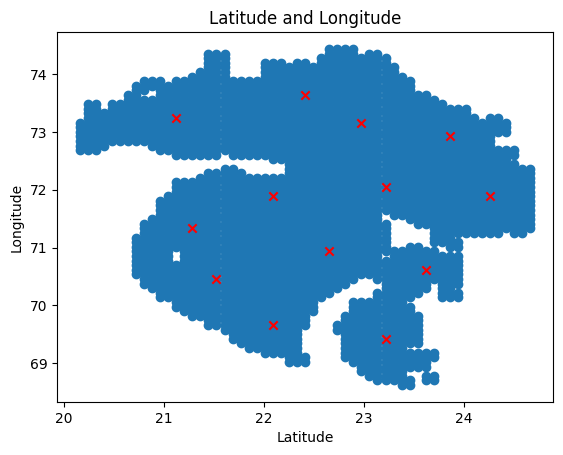

In [53]:
plot_depots(depots)

### Optimal Number of refineries (2018)

In [54]:
r = range(1,6)

Convergence in : 1 iterations
Convergence in : 5 iterations
Convergence in : 4 iterations
Convergence in : 3 iterations
Convergence in : 6 iterations


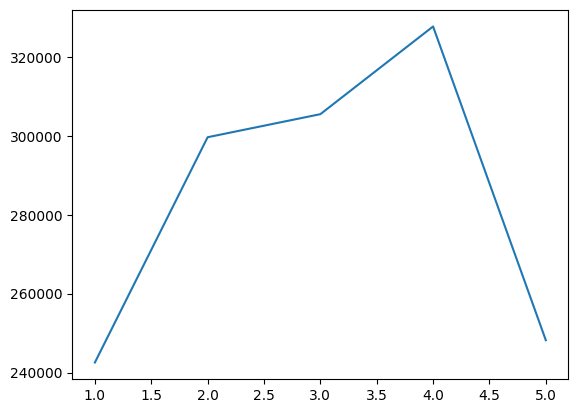

In [64]:
loss_r=[]
for i in r:
    year = '2018'
    biomass_per_depot = biomass_per_depo(k,clusters,year)
    weights = set_prob_ref(biomass_per_depot)
    #print(weights)
    refineries = get_refineries(i,depots,weights)
    
    count=0
    clusters_depots=[]
    for _ in range(30):
        prev=refineries
        refineries,clusters_depots = re_cluster_refineries(i,depots,refineries)
        if np.array_equal(prev,refineries):
            break
        #print(refineries)
        count+=1
    loss_r.append(loss_refinery(refineries,clusters_depots,depots))
    print(f"Convergence in : {count} iterations")
plt.plot(list(r),loss_r)